# Определение возраста покупателей

## Загружаем библиотеки и данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

### Извлекаем данные из папки, загружаем разметку

In [2]:
labels = pd.read_csv("/datasets/faces/labels.csv")

In [3]:
img_dir = "/datasets/faces/final_files"

In [4]:
# Генератор данных с нормализацией
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Обучающая выборка
train_gen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=img_dir,
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),   # размер изображений
    batch_size=32,
    class_mode="raw",         # для регрессии (возраст — число)
    subset="training",
    shuffle=True
)

Found 6073 validated image filenames.


In [5]:
# Валидационная выборка
val_gen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=img_dir,
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="validation",
    shuffle=True
)

Found 1518 validated image filenames.


## Исследовательский анализ данных

In [6]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


пропусков нет, тип данных в порядке

In [8]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Средний возраст - 31год (медиана 29), минимальный 1 год, максимальный 100 лет. Цифры реалистичные, выбросов нет.

In [9]:
labels.shape

(7591, 2)

Всего 7591 изображений. Посмотрим распределение возрастов:

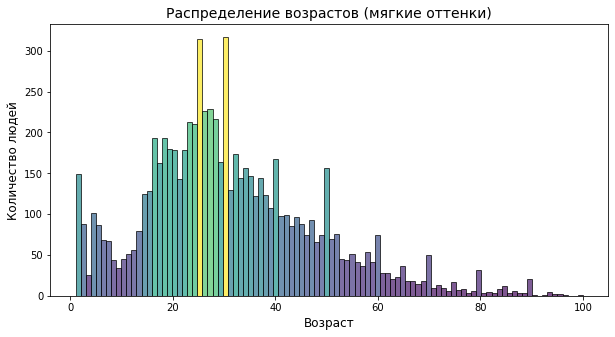

In [10]:
plt.figure(figsize=(10, 5)) 

counts, bins, patches = plt.hist(labels['real_age'], bins=100, edgecolor='black', alpha=0.7)

cmap = plt.cm.viridis

norm = plt.Normalize(min(counts), max(counts))
for count, patch in zip(counts, patches):
    patch.set_facecolor(cmap(norm(count)))

plt.title("Распределение возрастов (мягкие оттенки)", fontsize=14)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Количество людей", fontsize=12)

plt.show()

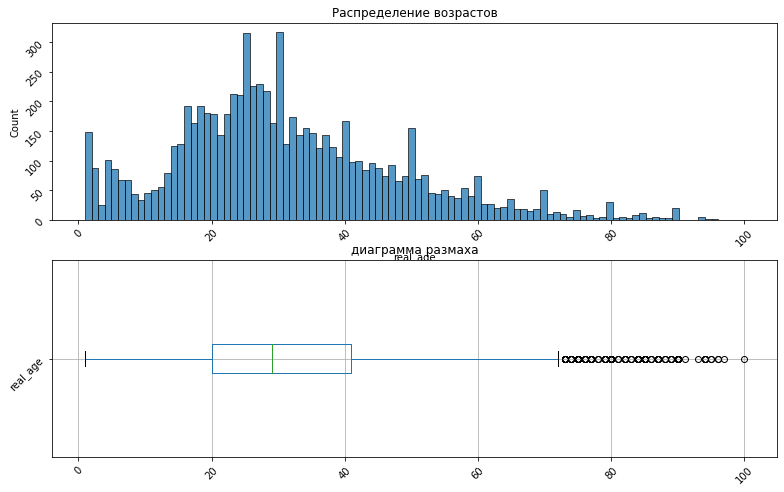

In [11]:
plt.figure(figsize=(13,8))
plt.subplot(2, 1, 1)
sns.histplot(data=labels, x='real_age', bins=100)
plt.title('Распределение возрастов')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

plt.subplot(2, 1, 2)
labels[['real_age']].boxplot(vert=False);
plt.xticks(rotation=45)
plt.yticks(rotation=45);
plt.title('диаграмма размаха')
plt.show();

Больше всего изображений с людьми в возрасте 20-30 лет. Меньше в возрасте 60+ (после 75 боксплот отмечает их выбросами, но это просто довольно редкие значения)

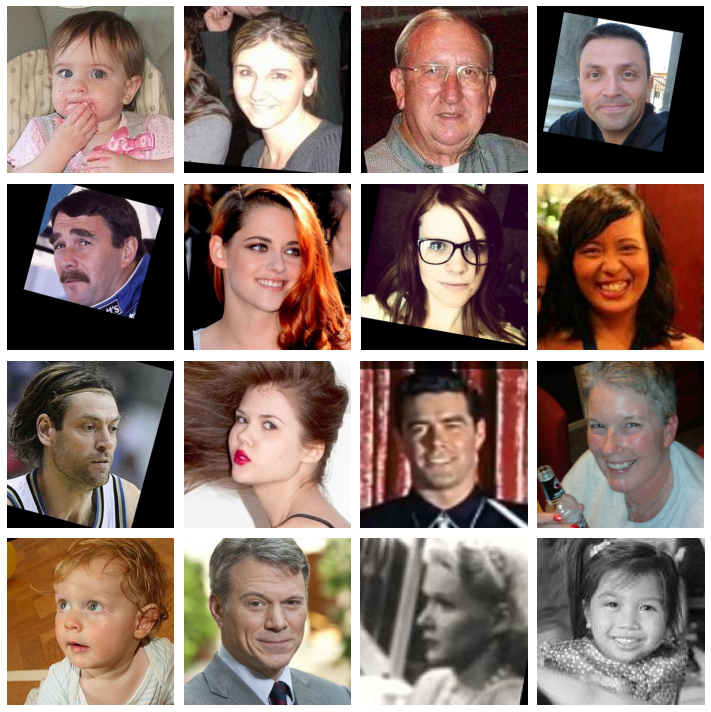

In [12]:
sample_files = random.sample(list(labels["file_name"]), 16)

fig = plt.figure(figsize=(10, 10))

for i, file_name in enumerate(sample_files):
    img_path = os.path.join(img_dir, file_name)
    img = Image.open(img_path)

    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(img)
    ax.axis("off")  # убираем оси

plt.tight_layout()
plt.show()

Выводы:

У нас не очень большая выборка (7591 изображение). Для обучения модели CNN с чистыми весами может быть маловато и может возникнуть необходимость в аугментациях . Однако для обучения предобученных моделей (например ResNet) этого может быть достаточно.
Также можно отметить, что в нашей выборке преобладают фотографии молодых людей и практически нет пожилых. Это значит, что возраст 60+ модель может плохо предсказывать и смещать предсказание в сторону среднего возраста. Возможно стоит использовать взвешенную функцию потерь или специальные техники балансировки.
Большинство изображений удовлетворительного качества, но встречаются и размытые фотографии. В таком случае лучше использовать предобученные модели, они более устойчивы

## Обучение модели

```python

def load_train(path, batch_size=32, seed=12345):

    labels = pd.read_csv(path + "/labels.csv")
    img_dir = path + "/final_files"
    
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True )
    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_dir,
        x_col="file_name",
        y_col="real_age",             
        target_size=(224, 224),       #или target_size=(224, 224)
        batch_size=batch_size,
        class_mode="raw",       
        subset='training',
        shuffle=True,
        seed=seed
    )
    return train_gen



def load_test(path, batch_size=32, seed=12345):
    labels = pd.read_csv(path + "/labels.csv")
    img_dir = path + "/final_files"
    
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_dir,
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="raw",
        subset='validation',
        shuffle=False,
        seed=seed
    )
    return test_gen



def create_model(input_shape=(224,224,3)):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mae',
    metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

model = create_model(input_shape=(224,224,3))

```

#скоринг с аугментацией

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 48s - loss: 11.0615 - mae: 11.0621 - val_loss: 27.3667 - val_mae: 27.4411
Epoch 2/10
178/178 - 39s - loss: 7.1618 - mae: 7.1621 - val_loss: 15.9488 - val_mae: 16.0305
Epoch 3/10
178/178 - 39s - loss: 6.1729 - mae: 6.1734 - val_loss: 14.1152 - val_mae: 14.1563
Epoch 4/10
178/178 - 39s - loss: 5.5404 - mae: 5.5411 - val_loss: 8.3828 - val_mae: 8.3719
Epoch 5/10
178/178 - 40s - loss: 4.9813 - mae: 4.9818 - val_loss: 7.2409 - val_mae: 7.2762
Epoch 6/10
178/178 - 39s - loss: 4.5944 - mae: 4.5947 - val_loss: 6.9291 - val_mae: 6.9440
Epoch 7/10
178/178 - 39s - loss: 4.3155 - mae: 4.3157 - val_loss: 6.3843 - val_mae: 6.3967
Epoch 8/10
178/178 - 40s - loss: 4.0911 - mae: 4.0914 - val_loss: 7.4818 - val_mae: 7.4985
Epoch 9/10
178/178 - 39s - loss: 3.8290 - mae: 3.8291 - val_loss: 6.2571 - val_mae: 6.2650
Epoch 10/10
178/178 - 38s - loss: 3.5598 - mae: 3.5601 - val_loss: 5.8036 - val_mae: 5.7922

60/60 - 9s - loss: 5.8036 - mae: 5.7922
Test MAE: 5.7922

```

## Анализ обученной модели

В данном поекте использовали сверточную нейронную сеть ResNet. В целом модель улавливает взаимосвязи и неплохо определяет возраст. Однако 6 лет в задаче опрелеления возраста все равно кажутся довольно большой погрешностью. Мы можем увидеть, что модель немного переобучается (что часто происходит с глубокими сетями). 

Для улучшения результата можно попробовать сделать линейную активацию на выходе вместо relu (а отрицательные значения либо интерпретировать как артефакт модели, либо обрезать на этапе постобработки — например, брать max(0, y_pred) при предсказании).

Как вариант можно попробовать двухэтапное обучение: сначала заморозить backbone.trainable = False, обучить только верхнюю голову.
Потом разморозить часть (или всю ResNet), но уже с очень маленьким lr=1e-5.
Также можно попробовать добавить аугментаций